# Intelligent Systems in Medical Imaging 2023

This Jupyter notebook is part of the course Intelligent Systems in Medical Imaging (ISMI) from Radboud University (Nijmegen, Netherlands), and it was developed by researchers of Radboud University Medical Center (Nijmegen, Netherlands).

You should have obtained this notebook by downloading it from the official Brightspace page of the course.

This notebook formulates an assignment as part of the ISMI course, and the content of this notebook should be used solely to develop a solution to this assignment. You should not make the code provided in this notebook, or your own solution, publicly available.

## Teaching Assistants

* Bram de Wilde (bram.dewilde@radboudumc.nl)
* Pierpaolo Vendittelli (pierpaolo.vendittelli@radboudumc.nl)
* Joeran Bosma (joeran.bosma@radboudumc.nl)
* Stephan Dooper (stephan.dooper@radboudumc.nl)

For questions about the assignments that go beyond the content, you can contact Bram de Wilde. Questions about the content are addressed in the tutorial sessions. You are also encouraged to use the Brightspace discussion forums to discuss content of the assignments. We will also keep an eye out there to help!

## Guidelines and instructions
Make sure you write code in any place that says "YOUR CODE HERE" by substituting `None` variables or by adding your own solution. Make sure you write in any place that says "YOUR ANSWER HERE" with your answers to the questions.

Please **do not delete or add any cells**.

Before you turn this problem in, make sure everything runs without errors. The easiest way to check this is to restart the kernel and run all cells (in the menubar, select Runtime$\rightarrow$Restart & Run All).

* Groups: You should work in **groups of 2 or 3 people**. (groups of 2 are preferred!)
* You are expected to work in Google Colab. If you run the notebooks locally, you may have to solve some issues yourself!
* Submit your **fully executed** notebook to Brightspace with file name format: `GroupN_NameSurname1_NameSurname2_NameSurname3.ipynb`
* The deadlines for all assignments are on Brightspace.
* Deadlines are soft, but make an effort to be on time. We prioritise feedback on assignments that are handed in before the deadline.
* Each assignment has 100 points, your grade is your total number of points divided by 10.
* The assignments are mandatory, but **do not count** towards your final grade for the course.
* For assignments where you have to submit to grand-challenge.org, use team name format `ismi-GroupN-nickname1`.
* When working with Google Colab, we advise you to download model checkpoints (.h5 files). This way you don't lose your checkpoint if your session times out. Also, don't forget to connect to a **GPU runtime** when training neural networks!
* In Google Colab, you can mount your Google Drive to save files, by clicking the Folder icon on the left, and then click the Mount Drive icon.

There are more detailed instructions on Brightspace on how to use Google Colab for the assignments. You can find it here: https://brightspace.ru.nl/d2l/le/content/333312/Home

## Students
Please fill in this cell with your names, e-mail address and s-numbers. This information will be used to grade your assignment.

* [Ivan Slootweg], [s1001424], [ilse.slootweg@ru.nl]
* [Sven van der Post], [s1028679], [sven.vanderpost@ru.nl]


# Assignment 6: Lung detection in chest X-ray

<img src="https://github.com/ivanslootweg/ISMI/blob/sven/assignment_6/figures/xray.jpeg?raw=1" width="200" height="200" align="right">

In this assignment, you will develop a system to automatically detect the lungs in a chest X-ray scan.
For this task you will use a single-shot network called [YOLO](https://arxiv.org/pdf/1506.02640.pdf) (You Only Look Once). Details on the YOLO (and the more recent YOLO9000) method can be found in the following papers:

  1. **You Only Look Once: Unified, Real-Time Object Detection** [https://arxiv.org/abs/1506.02640]
  2. **YOLO9000: Better, Faster, Stronger** [https://arxiv.org/abs/1612.08242] 

Chest X-ray is the most commonly acquired image in medicine. Chest X-ray uses a very small dose of ionizing radiation to produce pictures of the inside of the chest. It is used to evaluate the lungs, heart and chest wall and may be used to help diagnose shortness of breath, persistent cough, fever, chest pain or injury. It also may be used to help diagnose and monitor treatment for a variety of lung conditions such as pneumonia, emphysema and cancer. Because chest X-ray is fast and easy, it is particularly useful in emergency diagnosis and treatment.

Because of the difference in density between air, soft tissue and bone, the lungs appear much darker than their surroundings. Brighter regions in the lungs may indicate the presence of pathology.

# Tasks for this assignment 

The goal of this assignment is to get familiar with the YOLO architecture, loss function and training procedure, as well as the type of output it produces and how to transform it into actual predictions of bounding boxes. Additionally, you will get familiar with the problem of detecting lungs in chest X-ray. The models here could be re-trained in the future to detect more anatomical structures in chest X-ray images.
In order to get started with the YOLO architecture, we will first detect only the **right lung**, and once we are familiar with the whole training pipeline, then re-train to detect both left and right lungs.

The three main tasks of this assignment are:

* Task 1: Decode the network output to visualize the predicted bounding boxes for the right lung
* Task 2: Retrain the network on both lungs
* Task 3: Improve performance with data augmentation or alteration of the architecture

# Data

The data used in this assignment belong to the **CHESTXRAY14** dataset, which is publicly available and can be found at this link: https://nihcc.app.box.com/v/ChestXray-NIHCC. The dataset, released by the NIH, contains 112,120 frontal-view X-ray images of 30,805 unique patients, annotated with up to 14 different thoracic pathology labels using NLP methods on radiology reports.

For this assignment, we have selected 13,331 chest X-ray images from CHESTXRAY14 and generated bounding boxes containing the left and the right lungs. The coordinates of bounding boxes are extracted from a previously obtained segmentation of the lungs, available in our research group (lung segmentation is not available in the CHESTXARY14 dataset), as depicted in the following example:

<table width="100%" border="0">
  <tr>
  <td style="text-align:center">chest x-ray image</td>
  <td style="text-align:center">lung segmentation</td>
  <td style="text-align:center">bounding box</td>
  </tr>
  <tr>
  <td><img src="https://github.com/ivanslootweg/ISMI/blob/sven/assignment_6/figures/00000007_000.PNG?raw=1" alt="" align="center" /></td>
  <td><img src="https://github.com/ivanslootweg/ISMI/blob/sven/assignment_6/figures/00000007_000_segmentation.PNG?raw=1" alt="" align="center" /></td>
  <td><img src="https://github.com/ivanslootweg/ISMI/blob/sven/assignment_6/figures/00000007_000_overlay.PNG?raw=1" alt="" align="center"/></td>

</tr>
</table>


Bounding box data come in ```xml``` format, which is the format read by the YOLO training script that we will use in this assignment (more details about this in next cells).
An example of the content of the ```xml``` file for bounding boxes of right and left lung for the image ```00000004_000``` is the following:

```xml
<annotation verified="no">
  <folder>Lungs</folder>
  <filename>00000004_000</filename>
  <source>
    <database>Unknown</database>
  </source>
  <size>
    <width>512</width>
    <height>512</height>
    <depth>1</depth>
  </size>
  <segmented>0</segmented>
  <object>
    <name>RL</name>
    <pose>Unspecified</pose>
    <truncated>0</truncated>
    <difficult>0</difficult>
    <bndbox>
      <xmin>64</xmin>
      <ymin>62</ymin>
      <xmax>256</xmax>
      <ymax>490</ymax>
    </bndbox>
  </object>
  <object>
    <name>LL</name>
    <pose>Unspecified</pose>
    <truncated>0</truncated>
    <difficult>0</difficult>
    <bndbox>
      <xmin>298</xmin>
      <ymin>78</ymin>
      <xmax>450</xmax>
      <ymax>502</ymax>
    </bndbox>
  </object>
</annotation>
```

Among all the parameters that you can find there, the most important ones are the following:

* ```(width, height)```: image size
* ```(RL, LL)```: labels for Right Lung and Left Lung
* ```(xmin, xmax, ymin, ymax)```: coordinates of the top-left and bottom-right corners of the bounding box

It is important that to understand these parameters before you continue, because you will be using them in this assignment.

First, let's import the libraries needed for this assignment.
The code used in this notebook is developed based on this github repository: https://github.com/eriklindernoren/PyTorch-YOLOv3/, which is installable as the package `pytorchyolo`.

In [1]:
!pip3 install -q --upgrade ismi_utils pytorch_lightning pytorchyolo pillow==8.4.0 numpy==1.22 torch==1.11
!pip3 install -q --upgrade opencv-python==4.5.5.64

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 715.6/715.6 KB 21.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.9/42.9 KB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.8/16.8 MB 45.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 750.6/750.6 MB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 MB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 KB 38.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 KB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 KB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 KB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 KB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 60.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 79.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import torch
import pytorch_lightning as pl
from pytorchyolo.models import Darknet
from pytorchyolo.detect import detect_image
from pytorchyolo.utils.loss import compute_loss
from pytorchyolo.utils.utils import rescale_boxes, non_max_suppression
 
# matplotlib is needed to plot bounding boxes
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline

from tqdm.notebook import tqdm
import numpy as np
import json
import pickle
import time
import random
import xml.etree.ElementTree as ET # needed to read bounding boxes in xml format
from pathlib import Path
from ismi_utils import download_data
from PIL import Image
from torch.utils.data import random_split, DataLoader, Dataset
import pandas as pd
import shutil
import gc

### Downloading the data
Let's get the data and the weights of the pre-trained network needed for this assignment. Use the following cells to download the training, validation and test datasets and set your working directory.

In [3]:
workdir = Path(".")

Download **training set** and reference standard.

In [4]:
file_name = Path("train_lung_detection.zip")
download_data(file_name, link='https://surfdrive.surf.nl/files/index.php/s/kwSOdtP4t3dh5vD/download')

100%|██████████| 939M/939M [00:27<00:00, 35.2MB/s]


Download **test set** images.

In [5]:
file_name = Path("test_images_lung_detection.zip")
download_data(file_name, link='https://surfdrive.surf.nl/files/index.php/s/ZImBQSvSCpqF0i9/download')

100%|██████████| 310M/310M [00:09<00:00, 34.2MB/s]


At this point, you will see that the structure of ```workdir``` is the following:

```python
train                        # directory of training data
  images                     # training images
  xml                        # bounding boxes of right and left lungs 
  xml_right                  # bounding boxes of only right lung
test_images                  # test images
```

# Task 1: Get to know the data and the YOLO network (50 points)

In this section, you will:
* visualize chest X-ray images from the training set
* read bounding box data from the reference standard of the right lung
* plot the bounding box

After that, you will:
* setup a PyTorch Lightning training pipeline
* train a YOLO network to detect right lungs
* decode the output tensor in order to extract bounding box information
* visualize the predicted bounding box

### Load chest x-ray from training set
To get to know the data you will be working with, first load an example of a chest x-ray image from the training set and visualize it below.

**Note:** you can run the cells below multiple times to see the variability in the data! As you will notice, all images have a size of 512x512 px.

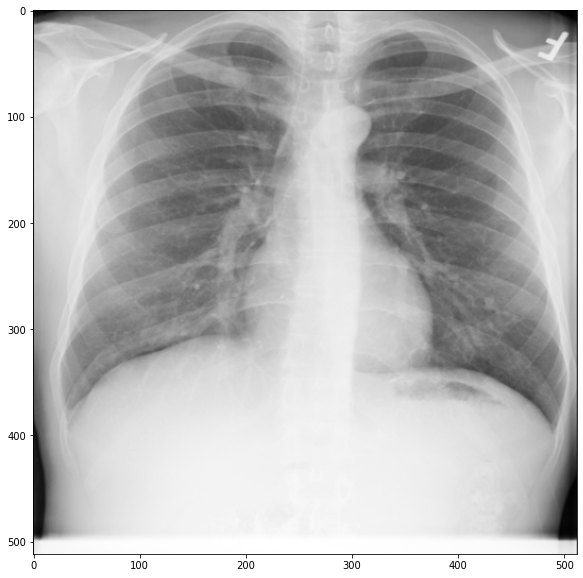

In [16]:
# Define directory of training images
train_dir_images = workdir / 'train' / 'images'

# Pick random training image
case = random.choice(list(train_dir_images.iterdir()))
case_filename = Path(case.name).with_suffix('.xml')

# Open image with opencv and visualize it
with Image.open(case) as im:
    image = np.array(im)
plt.figure(figsize=(10,10))
plt.imshow(image, cmap="gray")
plt.show()

**Question:** Can you explain what is causing the variance in image quality?

All images have the exact same size (512 x 512). The complete dataset contains 112,120 images, this amount of images probably infers that the images are taken by different doctors using different types of X-Ray machines with different spatial resolution and image resolution. These images had to be resized to the exact (512 x 512) format which means some of them had to be upscaled (bad image quality) or downscaled (good image quality)

All images in the training data are accompanied by annotations of bounding boxes that surround the right lung. Each annotation consists of a single ```xml``` file with coordinates that define the edges of the boxes (```xmin, xmax, ymin, ymax```).

Below you will find code that defines the class ```BoundingBox``` that stores information of bounding boxes, but in a slightly different format, using ```(x, y)``` as the coordinates of the center of the bounding box, and ```(w, h)``` as its width and height. It also implements additional variables related to classes, scores and labels, which will become clear later in this notebook.

In [7]:
class BoundingBox:
    def __init__(self, x, y, w, h, c = None, classes = None):
        """A bounding box object.
        
        Parameters
        ----------
        x: float
            x coordinate of the center of the box
        y: float
            y coordinate of the center of the box
        w: float
            width of the box
        h: float
            height of the box
        """
        self.x     = x
        self.y     = y
        self.w     = w
        self.h     = h
        
        self.c     = c
        self.classes = classes

        self.label = -1
        self.score = -1

    def get_label(self):
        if self.label == -1:
            self.label = np.argmax(self.classes)        
        return self.label
    
    def get_score(self):
        if self.score == -1:
            self.score = self.classes[self.get_label()]
        return self.score

Now we define a function to read an annotation in ```xml``` format and convert them into parameters to pass to the ```BoundingBox``` class. Most of the code of this function is provided, but you will have to implement the last part of it (replace the ```None``` values).

**Note**: as for many variables in the YOLO framework, ```(x, y, w, h)``` used in the ```BoundingBox``` class are normalized by the image height and width, meaning that they have values in the range ```[0.0, 1.0]```. Take this into account in your implementation!

In [17]:
def xml2bbox(xml_file):
    '''Convert xml file to bounding box
    
    Parameters
    ----------
    xml_file: str
        Path to xml file
        
    Returns
    -------
    bbox: BoundingBox object
        A BoundingBox object with parameters derived from the xml file
    '''
    # Parse structure of XML file
    tree = ET.parse(xml_file)

    for elem in tree.iter():
        if 'width' in elem.tag:
            width = int(elem.text) # image width
        if 'height' in elem.tag:
            height = int(elem.text) # image height

        for attr in list(elem):

            if 'bndbox' in attr.tag:
                for dim in list(attr):
                    if 'xmin' in dim.tag:
                        xmin = int(dim.text) # xmin bounding box
                    if 'ymin' in dim.tag:
                        ymin = int(dim.text) # ymin bounding box
                    if 'xmax' in dim.tag:
                        xmax = int(dim.text) # xmax bounding box
                    if 'ymax' in dim.tag:
                        ymax = int(dim.text) # ymax bounding box
    
    x = None
    y = None
    w = None
    h = None
    
    # YOUR CODE HERE

    w = (xmax - xmin) / width
    h = (ymax- ymin) / height
    x = xmin / width + w / 2
    y = ymin / height + h / 2

    return BoundingBox(x,y,w,h)

Now that we have defined the ```BoundingBox``` class and the ```xml2bbox``` function, you can get the bounding box corresponding to the XML file annotation for the chosen training image:

In [36]:
annotation_file = workdir / 'train' / 'xml_right' / case_filename
bbox = xml2bbox(annotation_file)

print(bbox.w * 512)
print(bbox.h * 512)
print(bbox.x * 512)
print(bbox.y * 512)

222.0
372.0
139.0
198.0


At this point, it is also convenient to define a function that allows us to plot bounding boxes using ```matplotlib```. We will use the ```Rectangle``` class for that. The following function reads a list of ```BoundingBox``` objects and returns a list of corresponding ```Rectangle``` objects.

In [37]:
def get_matplotlib_boxes(boxes, img_shape):
    plt_boxes = []
    for box in boxes:
        xmin  = int((box.x - box.w/2) * img_shape[1])
        xmax  = int((box.x + box.w/2) * img_shape[1])
        ymin  = int((box.y - box.h/2) * img_shape[0])
        ymax  = int((box.y + box.h/2) * img_shape[0])        
        plt_boxes.append(patches.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, fill=False, color='#00FF00', linewidth=2))
    return plt_boxes

Now we can use the code written so far to read, process and visualize the bounding box of the right lung together with the chest X-ray image visualized above:

Rectangle(xy=(28, 12), width=222, height=372, angle=0)


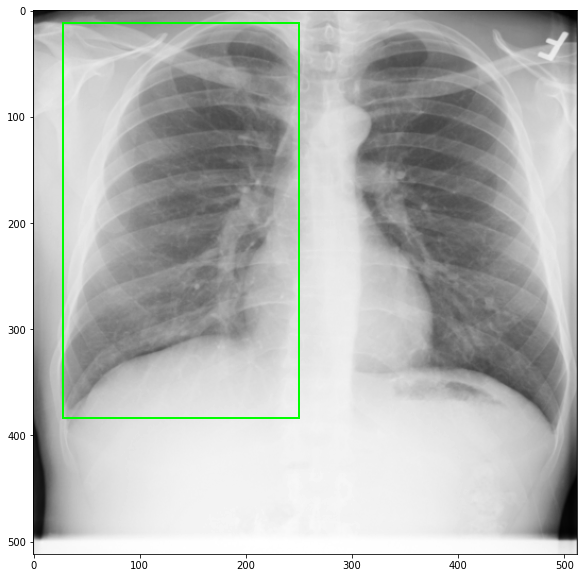

In [38]:
# Get bounding boxes in matplotlib format
plt_boxes = get_matplotlib_boxes([bbox],image.shape)

# Visualize image and bounding box
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, aspect='equal')
plt.imshow(image.squeeze(), cmap='gray')
for plt_box in plt_boxes:
    print(plt_box)
    ax.add_patch(plt_box)
plt.show()

**Question**: Why is it important to indicate the laterality (left/right lung) of the bounding box when working with chest x-rays?

You heart is positioned on the left side of your chest which automatically results in a white patch on the left lung when taking an X-Ray. 

### Pytorch Lightning Datamodule

In this assignment, you will also get familiar with the [PyTorch Lightning](https://lightning.ai/docs/pytorch/stable/) framework. This is a framework on top of PyTorch, which abstracts away a lot of implementation, similar to Keras for Tensorflow. Training models Pytorch Lightning goes best with Lightning Datamodules. This is a single object that contains datasets and dataloaders for training, validating and (optionally) testing models. We start with defining a Dataset. We limit the number of training images here to 100, to limit training time. Later, when training for detection of both lungs, you can extend this.

In [43]:
class RightLungDataset(Dataset):
    def __init__(self, image_dir, label_dir=None, transform=None):
        self.images = self.load_images(image_dir)
        self.case_ids = list(self.images.keys())
        if label_dir is not None:
            self.labels = self.load_labels(label_dir)
        else:
            self.labels = {case_id: [0, 0, 0, 0, 0] for case_id in self.case_ids} 
        self.transform = transform
        
    def load_images(self, data_dir):
        images = {}
        for image_path in data_dir.iterdir():
            case_id = image_path.stem
            images[case_id] = image_path
            
            if len(images) == 100:
                break
        return images
    
    def load_image(self, case_id):
        with Image.open(self.images[case_id]) as im:
            image = np.array(im).astype(np.uint8)
        return image
    
    def load_labels(self, data_dir):
        labels = {}
        for case_id in self.case_ids:
            annotation_file = workdir / 'train' / 'xml_right' / f"{case_id}.xml"
            bbox = xml2bbox(annotation_file)
            labels[case_id] = self.bbox_to_label(bbox)
        return labels
    
    def bbox_to_label(self, bbox):
        """convert to format [class x_center y_center width height]"""
        return [0, bbox.x, bbox.y, bbox.w, bbox.h]
    
    def visualize(self, idx):
        image, label = self[idx]
        
        # Remove channel dimension
        image = image[0]
        label = label[0]
        
        # Plot x-ray
        fig, ax = plt.subplots()
        ax.imshow(image, cmap="gray")
        
        # Plot box
        c, x, y, w, h = label
        xmin  = int((x - w/2) * image.shape[1])
        xmax  = int((x + w/2) * image.shape[1])
        ymin  = int((y - h/2) * image.shape[0])
        ymax  = int((y + h/2) * image.shape[0])        
        plt_box = patches.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, fill=False, color='#00FF00', linewidth=2)
        ax.add_patch(plt_box)
    
    def __getitem__(self, idx):
        case_id = self.case_ids[idx]
        image = self.load_image(case_id) / 255  
        label = self.labels[case_id]
        
        # Add channel dimension to image
        image = image[None, ...]

        # Cast label to correct shape
        label = np.array(label).reshape(-1, 5)
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

    def __len__(self):
        return len(self.images)


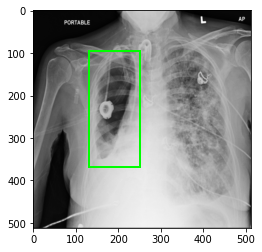

In [44]:
# Test your dataset implementation
train_dir = workdir / 'train'
right_lung_dataset = RightLungDataset(train_dir / "images", label_dir = train_dir / "xml_right")
right_lung_dataset.visualize(0)

With a working Pytorch Dataset, it is relatively straightforward to setup a Lightning Datamodule. Here we have layed out the structure for you. You can refer to the [documentation](https://pytorch-lightning.readthedocs.io/en/stable/data/datamodule.html) for more details.

In [45]:
class RightLungDatamodule(pl.LightningDataModule):
    def __init__(self, image_dir, label_dir, batch_size=8):
        super().__init__()
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.batch_size = batch_size
        self.train_fraction = 0.8
        
    def prepare_data(self):
        pass
        
    def setup(self, stage):
        full_set = RightLungDataset(self.image_dir, self.label_dir)
        train_size = int(self.train_fraction*len(full_set))
        val_size = len(full_set) - train_size
        self.train_dataset, self.val_dataset = random_split(full_set, [train_size, val_size])
        
    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, collate_fn=self.collate_fn)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, collate_fn=self.collate_fn)
    
    def collate_fn(self, batch):
        images, labels = list(zip(*batch))
        
        # Stack images
        images = torch.stack([torch.tensor(image) for image in images])
        
        # Add sample index to targets
        final_labels = []
        for i, boxes in enumerate(labels):
            boxes = np.concatenate([np.zeros([len(boxes),1]), boxes], axis = 1)
            boxes[:, 0] = i
            final_labels.append(torch.tensor(boxes))
        labels = torch.cat(final_labels, 0)
        
        return images, labels

### LightningModule

Now that we have setup the data inside the DataModule, it is time to define our model. In Pytorch Lightning, this is done by defining a LightningModule object, which contains your model and code to do a forward pass. The advantage of Lightning is that once you have the LightningModule defined, you can use the Pytorch Lightning Trainer to train your model. The trainer does a lot of heavy lifting for you, so that you need don't need to implement much yourself. Additionally, the Trainer has many useful flags you can set, to modify training behavior. 

In [ ]:
class YOLOv3(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.model = Darknet("yolov3-tiny.cfg")
        
    def forward(self, x):
        prediction = self.model(x.float())
        return prediction
    
    def training_step(self, batch, batch_idx):
        image, label = batch
        prediction = self.forward(image)
        loss, _ = compute_loss(prediction, label, self.model)
        
        self.log("train_loss", loss, on_step=False, on_epoch=True)
        
        return loss
    
    def validation_step(self, batch, batch_idx):
        self.train()
        image, label = batch
        prediction = self.forward(image)
        loss, _ = compute_loss(prediction, label, self.model)
        
        self.log("val_loss", loss, on_step=False, on_epoch=True)

        return loss
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

Now we have all the ingredients ready to start training: the DataModule and the LightningModule. The following two cells train the model and plot the loss curves. You can initially run it with the settings we pre-set. If you want, you can experiment later on with changing the learning rate, number of epochs, etc., if you want to improve performance.

In [ ]:
# Initialize the model
yolo_v3_model = YOLOv3()

# Empty the log directory and setup the logger
log_dir = Path("logs") / "right_lung" / "version_0"
if log_dir.is_dir():
    shutil.rmtree(log_dir)
logger = pl.loggers.CSVLogger("logs", name="right_lung", flush_logs_every_n_steps=1, version=0)

# Initialize trainer and train!
trainer = pl.Trainer(max_epochs=30, accelerator="gpu", devices=1, logger=logger, log_every_n_steps=1)
trainer.fit(yolo_v3_model, datamodule)

In [ ]:
# Plot train and validation loss

# Read the logged metrics.csv file
df = pd.read_csv(Path("logs") / "right_lung" / "version_0" / "metrics.csv")
train_loss = df.train_loss.dropna().values
val_loss = df.val_loss.dropna().values

# Make the plot
plt.figure()
plt.semilogy(train_loss, label="Train loss")
plt.semilogy(val_loss, label="Validation loss")
plt.ylabel("Loss value")
plt.xlabel("Epoch")
plt.legend()

When you pass a single image through the network, the raw output of the last yolo layer should have the following shape:

```(1, 3, 32, 32, 6)```

You can confirm that by running the next cell.

In [ ]:
# Pass single image through network
image, label = datamodule.train_dataset[0]
yolo_v3_model.train()
image = torch.tensor(image[None, ...])
raw_output = yolo_v3_model(image)[-1]
print(f"Raw output shape last yolo layer: {raw_output.shape}")

These values represent:

```(mini_batch_size, n_bbox_per_anchor, grid_h, grid_w, ???)```

In order to understand the meaning of the 5th dimension (which we indicate as ???), we ask you to do two things:

1. Read and try to understand the content of the ```non_max_suppression()``` function used in ```single_inference()``` defined below. You can find the code [here](https://github.com/eriklindernoren/PyTorch-YOLOv3/blob/3467db29ce17c753c519bdcc8a0b1d7bb5601cd8/pytorchyolo/utils/utils.py#L306)
2. Use the content of the lecture of this week, about object detection and YOLO

**Question**: What is the meaning of the 6 values in the 5th dimension of the raw output of the network?

YOUR ANSWER HERE

Now we can put all these things together and make a function that we can use to get predicted bounding boxes for a single image:

In [ ]:
def single_inference(model, image, conf_thres=0.02, nms_thres=0.4):
    """Do inference on a single image
    
    Parameters
    ----------
    model: LightningModule
    image: 3d np.array
    conf_thres: float
        Confidencen threshold (between 0 and 1) for predicted boxes
    nms_thres: float
        IoU threshold for non-maximum suppression
    
    Returns
    -------
    boxes: list of BoundingBoxes objects
    """
    model.eval()
    image = torch.tensor(image[None, ...])
    
    with torch.no_grad():
        detections = model(image)
        detections = non_max_suppression(detections, conf_thres, nms_thres)
        detections = rescale_boxes(detections[0], 512, (512, 512))
    
    detections = detections.numpy()
    
    boxes = []
    for detection in detections:
        xmin, ymin, xmax, ymax, confidence, class_idx = detection
        w = int(xmax - xmin)
        h = int(ymax - ymin)
        x = int(xmin + w/2)
        y = int(ymin + h/2)
        boxes.append(BoundingBox(x / 512, y / 512, w / 512, h / 512, c=class_idx))

    return boxes

We use the function we just defined to process 5 train and 5 validation images:

In [ ]:
# Plot 5 training images
for idx in range(5):
    image, label = datamodule.train_dataset[idx]
    boxes = single_inference(yolo_v3_model, image)

    # Get bounding boxes in matplotlib format
    plt_boxes = get_matplotlib_boxes(boxes,image[0].shape)

    # Visualize image and bounding box
    fig = plt.figure()
    ax = fig.add_subplot(111, aspect='equal')
    plt.imshow(image.squeeze(), cmap='gray')
    for plt_box in plt_boxes:
        ax.add_patch(plt_box)
        
    plt.title(f"Training image {idx}")
    
# Plot 5 validation images
for idx in range(5):
    image, label = datamodule.val_dataset[idx]
    boxes = single_inference(yolo_v3_model, image)

    # Get bounding boxes in matplotlib format
    plt_boxes = get_matplotlib_boxes(boxes,image[0].shape)

    # Visualize image and bounding box
    fig = plt.figure()
    ax = fig.add_subplot(111, aspect='equal')
    plt.imshow(image.squeeze(), cmap='gray')
    for plt_box in plt_boxes:
        ax.add_patch(plt_box)
    plt.title(f"Validation image {idx}")
    
gc.collect()  # This prevents RAM from filling up each time we run this cell

**Question**: For this first test, we used a threshold ```conf_thres=0.02```, which (often) results in a meaningful bounding box for the right lung. Try to see what happens if you pick a much lower threshold, for example ```conf_thres=0.0```, or ```conf_thres=0.001``` and explain what you see. Can you find a threshold for which you get one (meaningful) false positive?

YOUR ANSWER HERE

Now it would be good to check the performance of YOLO on the entire test set. Since the test set is far too large to process in this manner, if you think that the output of the cell above seems to be correct, run the cell below to process the first 5 images in the test dataset and visualize the output. Again, you can play with the  ```conf_thres``` and observe the differences.

In [ ]:
test_dir = workdir / 'test_images'
test_dataset = RightLungDataset(test_dir)

conf_thres = 0.01

# Plot 5 test images
for idx in range(5):
    image, label = test_dataset[idx]
    boxes = single_inference(yolo_v3_model, image, conf_thres = conf_thres)

    # Get bounding boxes in matplotlib format
    plt_boxes = get_matplotlib_boxes(boxes,image[0].shape)

    # Visualize image and bounding box
    fig = plt.figure()
    ax = fig.add_subplot(111, aspect='equal')
    plt.imshow(image.squeeze(), cmap='gray')
    for plt_box in plt_boxes:
        ax.add_patch(plt_box)
    plt.title(f"Test image {idx}")
    
gc.collect()  # This prevents RAM from filling up each time we run this cell

# Task 2. Re-train YOLO to detect two lungs! (50 points)
Now that we have familiarized with the data, the network architecture and the output it produces, we can start re-training YOLO to detect both lungs. First, we look at a bit more detail at the loss function.

### Loss function
We have seen in the lecture that the YOLO network has a loss function that contains several elements. Here we report the formula of the loss function, and if you want you can check out the implementation we are using [here](https://github.com/eriklindernoren/PyTorch-YOLOv3/blob/3467db29ce17c753c519bdcc8a0b1d7bb5601cd8/pytorchyolo/utils/loss.py#L58). As you will see, it's a quite long and complex piece of code. We report the formula and the code here for completeness, but you don't have to worry too much about the details, understanding on a high level is enough.

$$\begin{multline}
\lambda_\textbf{coord}
\sum_{i = 0}^{S^2}
    \sum_{j = 0}^{B}
     L_{ij}^{\text{obj}}
            \left[
            \left(
                x_i - \hat{x}_i
            \right)^2 +
            \left(
                y_i - \hat{y}_i
            \right)^2
            \right]
+ \lambda_\textbf{coord} 
\sum_{i = 0}^{S^2}
    \sum_{j = 0}^{B}
         L_{ij}^{\text{obj}}
         \left[
        \left(
            \sqrt{w_i} - \sqrt{\hat{w}_i}
        \right)^2 +
        \left(
            \sqrt{h_i} - \sqrt{\hat{h}_i}
        \right)^2
        \right]
+ \sum_{i = 0}^{S^2}
    \sum_{j = 0}^{B}
        L_{ij}^{\text{obj}}
        \left(
            C_i - \hat{C}_i
        \right)^2
\\
+ \lambda_\textrm{noobj}
\sum_{i = 0}^{S^2}
    \sum_{j = 0}^{B}
    L_{ij}^{\text{noobj}}
        \left(
            C_i - \hat{C}_i
        \right)^2
+ \sum_{i = 0}^{S^2}
L_i^{\text{obj}}
    \sum_{c \in \textrm{classes}}
        \left(
            p_i(c) - \hat{p}_i(c)
        \right)^2
\end{multline}$$

**Question**: Which of the 5 terms in the loss function penalize the network for predicting bounding boxes in the wrong place? And which term penalizes for the wrong bounding box size?

YOUR ANSWER HERE

### DataModule

We will repeat the same steps for the single-lung training, starting with defining a LightningModule based on a Dataset. Here we add an argument ```n_images``` to control the number of training images loaded. In the previous dataset, we already fixed this at 100. You can increase to improve performance, but this will cost you training time. We recommend to experiment with 100 images first.

In [ ]:
class LungsDataset(Dataset):
    def __init__(self, image_dir, label_dir=None, transform=None, n_images=100):
        self.n_images = n_images
        self.images = self.load_images(image_dir)
        self.case_ids = list(self.images.keys())
        if label_dir is not None:
            self.labels = self.load_labels(label_dir)
        else:
            self.labels = {case_id: [0, 0, 0, 0, 0] for case_id in self.case_ids} 
        self.transform = transform
        
        
    def load_images(self, data_dir):
        images = {}
        for image_path in data_dir.iterdir():
            case_id = image_path.stem
            images[case_id] = image_path
            
            if len(images) == self.n_images:
                break
        return images
    
    def load_image(self, case_id):
        with Image.open(self.images[case_id]) as im:
            image = np.array(im).astype(np.uint8)
        return image
    
    def load_labels(self, data_dir):
        labels = {}
        for case_id in self.case_ids:
            annotation_file = data_dir / f"{case_id}.xml"
            labels[case_id] = self.xml_to_label(annotation_file)

        return labels
    
    def xml_to_label(self, xml_path):
        label = []
        tree = ET.parse(xml_path)
        root = tree.getroot()
        for box in root.findall("object"):
            # Find class index
            class_name = box.find("name").text
            if class_name == "RL":
                class_idx = 0
            if class_name == "LL":
                class_idx = 1
                
            # Find coordinates
            coordinates = box.find("bndbox")
            xmin = int(coordinates.find("xmin").text)
            ymin = int(coordinates.find("ymin").text)
            xmax = int(coordinates.find("xmax").text)
            ymax = int(coordinates.find("ymax").text)
            
            x = (xmin + ((xmax - xmin)/2)) / 512
            y = (ymin + ((ymax - ymin)/2)) / 512
            w = (xmax - xmin) / 512
            h = (ymax - ymin) / 512
            
            label.append([class_idx, x, y, w, h])

        return label
    
    def visualize(self, idx):
        image, label = self[idx]
        
        # Remove channel dimension
        image = image[0]

        # Plot x-ray
        fig, ax = plt.subplots()
        ax.imshow(image, cmap="gray")
    
        # Plot box
        for box_idx in range(label.shape[0]):
            box = label[box_idx]
            c, x, y, w, h = box
            if c == 0:
                color = "green"
                text_label = "right"
            if c == 1:
                color = "red"
                text_label = "left"
            
            xmin  = int((x - w/2) * image.shape[1])
            xmax  = int((x + w/2) * image.shape[1])
            ymin  = int((y - h/2) * image.shape[0])
            ymax  = int((y + h/2) * image.shape[0])        
            plt_box = patches.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, fill=False, color=color, label = text_label, linewidth='2')
            ax.add_patch(plt_box)
        plt.legend()
        
    def __getitem__(self, idx):
        case_id = self.case_ids[idx]
        image = self.load_image(case_id) / 255  
        label = self.labels[case_id]
        
        # Add channel dimension to image
        image = image[None, ...]

        # Cast label to correct shape
        label = np.array(label).reshape(-1, 5)
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

    def __len__(self):
        return len(self.images)

In [ ]:
# Test your dataset implementation
train_dir = workdir / 'train'
lungs_dataset = LungsDataset(train_dir / "images", label_dir = train_dir / "xml")
lungs_dataset.visualize(0)

In [ ]:
class LungsDatamodule(pl.LightningDataModule):
    def __init__(self, image_dir, label_dir, n_images = 100, batch_size=8):
        super().__init__()
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.batch_size = batch_size
        self.n_images = n_images
        self.train_fraction = 0.8
        
    def prepare_data(self):
        pass
        
    def setup(self, stage):
        full_set = LungsDataset(self.image_dir, self.label_dir, n_images = self.n_images)
        train_size = int(self.train_fraction*len(full_set))
        val_size = len(full_set) - train_size
        self.train_dataset, self.val_dataset = random_split(full_set, [train_size, val_size])
        
    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, collate_fn=self.collate_fn)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, collate_fn=self.collate_fn)
    
    def collate_fn(self, batch):
        images, labels = list(zip(*batch))
        
        # Stack images
        images = torch.stack([torch.tensor(image) for image in images])
        
        # Add sample index to targets
        final_labels = []
        for i, boxes in enumerate(labels):
            boxes = np.concatenate([np.zeros([len(boxes),1]), boxes], axis = 1)
            boxes[:, 0] = i
            final_labels.append(torch.tensor(boxes))
        labels = torch.cat(final_labels, 0)
        
        return images, labels

Here we define a new LightningModule, with a few changes compared to the previous implementation.

- There is now an argument in the init that sets the learning rate, for easier experimentation
- The model is based on a new config `yolov3-tiny-two-lungs.cfg`

In [ ]:
class YOLOv3_two_lungs(pl.LightningModule):
    def __init__(self, lr=1E-3):
        super().__init__()
        self.lr = lr
        self.model = Darknet("yolov3-tiny-two-lungs.cfg")
        
    def forward(self, x):
        prediction = self.model(x.float())
        return prediction
    
    def training_step(self, batch, batch_idx):
        image, label = batch
        prediction = self.forward(image)
        loss, _ = compute_loss(prediction, label, self.model)
        
        self.log("train_loss", loss, on_step=False, on_epoch=True)
        
        return loss
    
    def validation_step(self, batch, batch_idx):
        self.train()
        image, label = batch
        prediction = self.forward(image)
        loss, _ = compute_loss(prediction, label, self.model)
        
        self.log("val_loss", loss, on_step=False, on_epoch=True)

        return loss
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        return optimizer

In [ ]:
# Set train parameters
batch_size = 8
n_images = 100
max_epochs = 10
lr = 1E-3

# Initialize the model and datamodule
yolo_v3_model_two_lungs = YOLOv3_two_lungs(lr = lr)
datamodule = LungsDatamodule(train_dir / "images", label_dir = train_dir / "xml", n_images = n_images, batch_size=batch_size)

# Empty the log directory and setup the logger
log_dir = Path("logs") / "two_lungs" / "version_0"
if log_dir.is_dir():
    shutil.rmtree(log_dir)
logger = pl.loggers.CSVLogger("logs", name="two_lungs", flush_logs_every_n_steps=1, version=0)

# Initialize trainer and train!
trainer = pl.Trainer(max_epochs=max_epochs, accelerator="gpu", devices=1, logger=logger, log_every_n_steps=1)
trainer.fit(yolo_v3_model_two_lungs, datamodule)

In [ ]:
# Plot train and validation loss

# Read the logged metrics.csv file
df = pd.read_csv(Path("logs") / "two_lungs" / "version_0" / "metrics.csv")
train_loss = df.train_loss.dropna().values
val_loss = df.val_loss.dropna().values

# Make the plot
plt.figure()
plt.semilogy(train_loss, label="Train loss")
plt.semilogy(val_loss, label="Validation loss")
plt.ylabel("Loss value")
plt.xlabel("Epoch")
plt.legend()

The following cell implements a new function to visualize predictions (in dashed lines) against the ground truth labels (in solid lines) on train and validation images. The left lung is shown in red, the right lung in green. 

In [ ]:
def visualize_inference_two_lungs(image, label, boxes, title=""):
    # Remove channel dimension
    image = image[0]

    # Plot x-ray
    fig, ax = plt.subplots()
    ax.imshow(image, cmap="gray")

    # Plot ground truth boxes
    for box_idx in range(label.shape[0]):
        box = label[box_idx]
        c, x, y, w, h = box
        if c == 0:
            color = "green"
            text_label = "right"
        if c == 1:
            color = "red"
            text_label = "left"

        xmin  = int((x - w/2) * image.shape[1])
        xmax  = int((x + w/2) * image.shape[1])
        ymin  = int((y - h/2) * image.shape[0])
        ymax  = int((y + h/2) * image.shape[0])        
        plt_box = patches.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, fill=False, color=color, label = text_label, linewidth='2')
        ax.add_patch(plt_box)
        
    # Plot predicted boxes
    for box in boxes:
        c, x, y, w, h = box.c, box.x, box.y, box.w, box.h
        if c == 0:
            color = "green"
            text_label = "right"
        if c == 1:
            color = "red"
            text_label = "left"

        xmin  = int((x - w/2) * image.shape[1])
        xmax  = int((x + w/2) * image.shape[1])
        ymin  = int((y - h/2) * image.shape[0])
        ymax  = int((y + h/2) * image.shape[0])        
        plt_box = patches.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, fill=False, color=color, label = text_label, linewidth='2', linestyle="--")
        ax.add_patch(plt_box)
   
    plt.title(title)

You can use the following cell to tune the confidence and non-maximum suppression thresholds visually.

In [ ]:
conf_thres=0.5
nms_thres=0.5

# Plot 5 training images
for idx in range(5):
    image, label = datamodule.train_dataset[idx]
    boxes = single_inference(yolo_v3_model_two_lungs, image, conf_thres=conf_thres, nms_thres = nms_thres)
    visualize_inference_two_lungs(image, label, boxes, title=f"Training image {idx}")
    
# Plot 5 validation images
for idx in range(5):
    image, label = datamodule.val_dataset[idx]
    boxes = single_inference(yolo_v3_model_two_lungs, image, conf_thres=conf_thres, nms_thres = nms_thres)
    visualize_inference_two_lungs(image, label, boxes, title=f"Validation image {idx}")
    
gc.collect()  # This prevents RAM from filling up each time we run this cell

At this point, experiment with the various training and inference parameters until you are satisfied with the validation performance. The final step is to upload your results to grand challenge, to see how you stack up to your fellow students. Running the next cell gives you a csv that you can upload here: https://ismi-chestxray.grand-challenge.org/

In [ ]:
# Inference parameters
conf_thres = 0.5
nms_thres = 0.5

test_dir = workdir / 'test_images'
header = 'filename,RL_xmin,RL_ymin,RL_xmax,RL_ymax,LL_xmin,LL_ymin,LL_xmax,LL_ymax\n'
csv_file = 'test_set.csv'

# Load checkpoint
for ckpt_path in (Path("logs") / "two_lungs" / "version_0" / "checkpoints").glob("*.ckpt"):
    print(ckpt_path)
    model = YOLOv3_two_lungs.load_from_checkpoint(ckpt_path)
model.eval()

with open(csv_file, 'w') as csv_out:
    csv_out.write(header)

for image_path in tqdm(list(test_dir.iterdir())):
    with Image.open(image_path) as im:
        image = np.array(im).astype(np.uint8)
    image = image / 255  
    image = image[None, ...]
    image = torch.tensor(image[None, ...])

    with torch.no_grad():
        detections = model(image)
        detections = non_max_suppression(detections, conf_thres, nms_thres)
        detections = rescale_boxes(detections[0], 512, (512, 512))
    
    detections = detections.numpy()

    # Pick highest confidence right lung
    right_lung = [0, 0, 0, 0]  # By default we find no box
    for box_idx in range(detections.shape[0]):
        xmin, ymin, xmax, ymax, confidence, class_idx = detections[box_idx]
        if class_idx == 0:
            right_lung = [int(xmin), int(ymin), int(xmax), int(ymax)]
            break

    # Pick highest confidence left lung
    left_lung = [0, 0, 0, 0]  # By default we find no box
    for box_idx in range(detections.shape[0]):
        xmin, ymin, xmax, ymax, confidence, class_idx = detections[box_idx]
        if class_idx == 1:
            left_lung = [int(xmin), int(ymin), int(xmax), int(ymax)]
            break
    
    line = f"{image_path.stem},{right_lung[0]},{right_lung[1]},{right_lung[2]},{right_lung[3]},{left_lung[0]},{left_lung[1]},{left_lung[2]},{left_lung[3]}"

    with open(csv_file, 'a') as csv_out:
        csv_out.write(line + '\n')

# Final questions task 2

**Question**: We have not explicitly evaluated the performance of the networks in this assignment. Suppose we want to evaluate the left lung detection performance with a *case-based AUC score*, this means giving each case a single score and calculating the AUC over the entire dataset. Describe how you would calculate the case-based ROC/AUC from a set of bounding boxes with confidence scores.

YOUR ANSWER HERE

**Question**: Is the case-based AUC score a good choice of metric for evaluating left lung detection performance? Explain why/why not.

YOUR ANSWER HERE

**Question**: Suppose that instead of the big dataset of this assignment (>10,000 images), you only had access to 100 chest X-ray images. You have to ask a radiologist to annotate your data and can ask him to either (1) annotate the lungs with bounding boxes, or (2) annotate with a lung segmentation. Which choice would probably give you the best performing model and why?

YOUR ANSWER HERE

# Task 3: Improve your results! (0 points)

The main message of the steps of this assignment so far is that YOLO is a powerful architecture for object detection, and that it works very well for lungs detection in chest x-ray images. There are, however, still quite a few things unexplored and probably you can improve your performance by a lot. If you are up for a challenge, use the empty cells below to explore one or both of the following:

- Configure the architecture by copying `yolov3-tiny-two-lungs.cfg` and editing parameters.
- Explore data augmentation, by passing a `transform` to the dataset/dataloader.

For grading and feedback purposes, it helps if you document your exploration, either with figures or comments/text in cells.